In [1]:
import os
os.chdir("../../")

from scipy.stats import norminvgauss
import numpy as np
import matplotlib.pyplot as plt
from seaborn import kdeplot
import torch

from distributions.NormalInverseGaussian import NormalInverseGaussian
from torch.distributions import Normal, Uniform
from models.nig import Nig

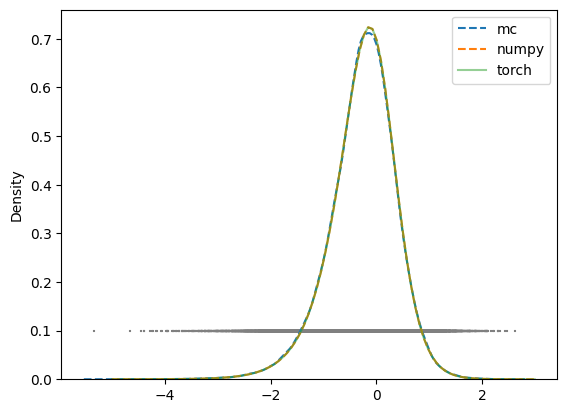

In [2]:
alpha = 3.0
delta = 1.0
beta = -1.0
mu = 0.1

evals = np.linspace(-5, 3, 100)
pdf = norminvgauss.pdf(evals, a=alpha*delta, b=beta*delta, loc=mu, scale=delta)

mu = torch.tensor(mu)
alpha = torch.tensor(alpha)
beta = torch.tensor(beta)
delta = torch.tensor(delta)
evals = torch.linspace(-5, 3, 100)
torch_pdf = torch.exp(NormalInverseGaussian(mu, alpha, beta, delta).log_prob(evals))

samples = NormalInverseGaussian(mu, alpha, beta, delta).sample((100000,))
mc_pdf = kdeplot(samples, label='mc', linestyle='--')

plt.plot(evals, pdf, label='numpy', linestyle='--')
plt.plot(evals, torch_pdf, label='torch', alpha=0.5)
plt.scatter(samples, 0.1 * torch.ones_like(samples), marker='+', s=1, c='grey')
plt.legend()
plt.show()

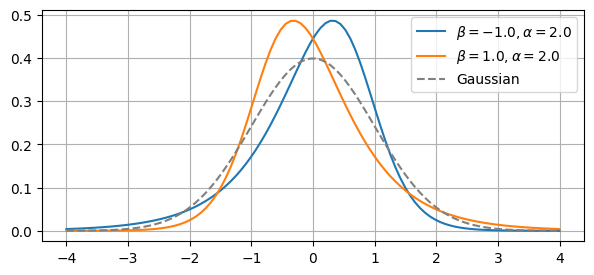

In [3]:
evals = torch.linspace(-4, 4, 100)

fig = plt.figure(figsize=(7, 3))

alpha = torch.tensor(2.0)
beta = torch.tensor(-1.0)
gamma = torch.sqrt(alpha**2 - beta**2)
delta = gamma**3 / alpha**2
mu = - delta * beta / gamma
torch_pdf = torch.exp(NormalInverseGaussian(mu, alpha, beta, delta).log_prob(evals))
plt.plot(evals, torch_pdf, label=rf'$\beta={beta.item():.1f}, \alpha={alpha.item():.1f}$')

alpha = torch.tensor(2.0)
beta = torch.tensor(1.0)
gamma = torch.sqrt(alpha**2 - beta**2)
delta = gamma**3 / alpha**2
mu = - delta * beta / gamma
torch_pdf = torch.exp(NormalInverseGaussian(mu, alpha, beta, delta).log_prob(evals))
plt.plot(evals, torch_pdf, label=rf'$\beta={beta.item():.1f}, \alpha={alpha.item():.1f}$')

gaussian_pdf = torch.exp(Normal(loc=torch.tensor(0.0), scale=torch.tensor(1.0)).log_prob(evals))

plt.plot(evals, gaussian_pdf, label='Gaussian', c='grey', linestyle='--')
plt.grid()
plt.legend()

In [4]:
alpha_true = torch.tensor(150.0)
beta_true = torch.tensor(-50.0)
gamma_true = torch.sqrt(alpha_true**2 - beta_true**2)
delta_true = 0.2**2 * gamma_true**3 / alpha_true**2
mu_true = 0.1 - delta_true * beta_true / gamma_true

skew = 3 * beta_true / (alpha_true * torch.sqrt(delta_true * gamma_true))
ekurt = 3 * (1 + 4 * beta_true**2 / alpha_true**2) / (delta_true * gamma_true)

print(skew)
print(ekurt)

tensor(-0.0375)
tensor(0.0061)


return mean=0.100, std=0.200, skew=-0.030, kurt=0.031


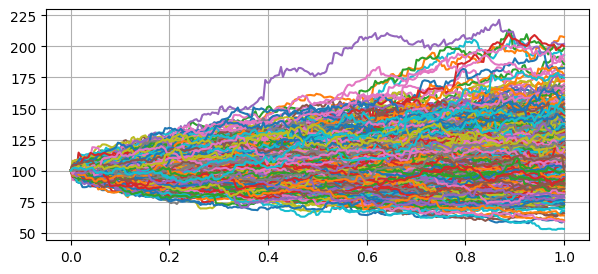

In [5]:
torch.manual_seed(42)

dt = torch.tensor(1 / 252)
T = 1.0
S0 = torch.tensor(100.0)

#alpha_true = torch.tensor(150.0)
#beta_true = torch.tensor(-50.0)
#gamma_true = torch.sqrt(alpha_true**2 - beta_true**2)
#delta_true = 0.2**2 * gamma_true**3 / alpha_true**2
#mu_true = 0.1 - delta_true * beta_true / gamma_true

mu_true = torch.tensor(0.1)
sigma_true = torch.tensor(0.2)
xi_true = torch.tensor(-1.0)
eta_true = torch.tensor(0.01)

nig_model = Nig(mu_true, sigma_true, xi_true, eta_true)
mean, std, skew, kurt = nig_model.get_moments()
print(f'return mean={mean:.3f}, std={std:.3f}, skew={skew:.3f}, kurt={kurt:.3f}')

S = nig_model.simulate(S0, dt, T, M=1000)

plt.figure(figsize=(7, 3))
plt.plot(torch.linspace(0, T, S.shape[0]), S.detach())
plt.grid()
plt.show()

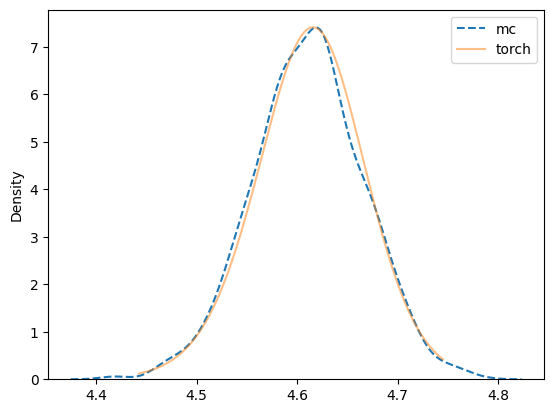

In [6]:
day = 20
log_r = torch.log(S[day, :])

mc_pdf = kdeplot(log_r, label='mc', linestyle='--')

evals = torch.linspace(85, 115, 1000)
pdf = torch.exp(nig_model.transition(S0, evals, delta_t=day/252))
plt.plot(torch.log(evals), pdf.detach(), label='torch', alpha=0.5)

#plt.plot(torch.log(evals), gaussian_pdf.detach(), label='gaussian', alpha=0.5)
#plt.xlim((4.5, 4.7))
plt.legend()
plt.show()

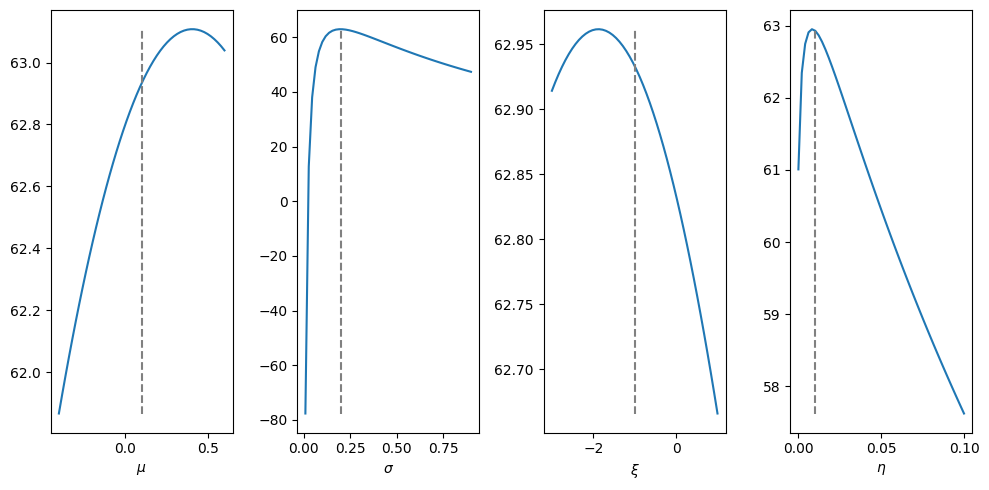

In [7]:
# Plot the likelihood slices, for one path only.
t = S.shape[0] - 1
spot = S[:, 0]

beta = 0.95
window = None

fig, axs = plt.subplots(figsize=(10, 5), nrows=1, ncols=4)

mus = torch.linspace(mu_true - 0.5, mu_true + 0.5, 50)
log_likelihood = torch.zeros_like(mus)
for i, mu in enumerate(mus):
    model = Nig(mu, sigma_true, xi_true, eta_true)
    log_likelihood[i] = model.forward(spot, t, delta_t=dt, beta=beta, window=window)
axs[0].plot(mus, log_likelihood.detach())
axs[0].vlines(mu_true, ymin=log_likelihood.min().detach(), ymax=log_likelihood.max().detach(), color='grey', linestyle='--')
axs[0].set_xlabel(r'$\mu$')

sigmas = torch.linspace(sigma_true - 0.19, sigma_true + 0.7, 50)
log_likelihood = torch.zeros_like(sigmas)
for i, sigma in enumerate(sigmas):
    model = Nig(mu_true, sigma, xi_true, eta_true)
    log_likelihood[i] = model.forward(spot, t, delta_t=dt, beta=beta, window=window)

axs[1].plot(sigmas, log_likelihood.detach())
axs[1].vlines(sigma_true, ymin=log_likelihood.min().detach(), ymax=log_likelihood.max().detach(), color='grey', linestyle='--')
axs[1].set_xlabel(r'$\sigma$')

xis = torch.linspace(xi_true - 2.0, xi_true + 2.0, 50)
log_likelihood = torch.zeros_like(xis)
for i, xi in enumerate(xis):
    model = Nig(mu_true, sigma_true, xi, eta_true)
    log_likelihood[i] = model.forward(spot, t, delta_t=dt, beta=beta, window=window)

axs[2].plot(xis, log_likelihood.detach())
axs[2].vlines(xi_true, ymin=log_likelihood.min().detach(), ymax=log_likelihood.max().detach(), color='grey', linestyle='--')
axs[2].set_xlabel(r'$\xi$')

etas = torch.linspace(1e-4, 0.1, 50)
log_likelihood = torch.zeros_like(etas)
for i, eta in enumerate(etas):
    model = Nig(mu_true, sigma_true, xi_true, eta)
    log_likelihood[i] = model.forward(spot, t, delta_t=dt, beta=beta, window=window)

axs[3].plot(etas, log_likelihood.detach())
axs[3].vlines(eta_true, ymin=log_likelihood.min().detach(), ymax=log_likelihood.max().detach(), color='grey', linestyle='--')
axs[3].set_xlabel(r'$\eta$')

plt.tight_layout()

/Users/ninocourtecuisse/Documents/ETHZ/MastersThesis/MastersThesis/.venv/lib/python3.11/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4316.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


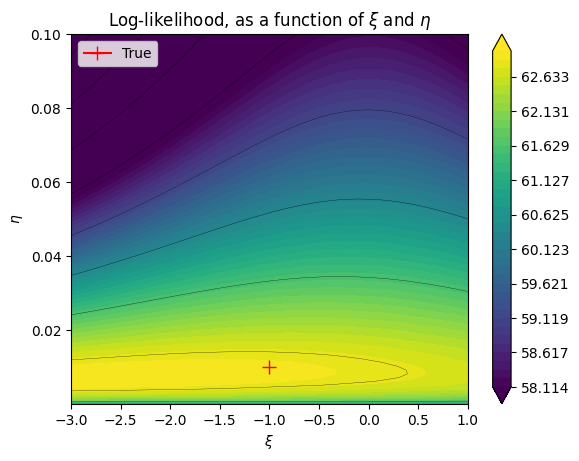

In [8]:
# Contour plot of the likelihood, as a function of alpha, beta
t = S.shape[0] - 1
spot = S[:, 0]

beta = 0.95
window = None

xis = torch.linspace(xi_true - 2, xi_true + 2, 100)
etas = torch.linspace(1e-4, 0.1, 100)
xis, etas = torch.meshgrid(xis, etas)
log_likelihood = torch.zeros(size=(100, 100))
for i in range(xis.shape[0]):
    for j in range(xis.shape[1]):
        model = Nig(mu_true, sigma_true, xis[i, j], etas[i, j])
        log_likelihood[i, j] = model.forward(spot, t, delta_t=dt, beta=beta, window=window)

mean = torch.mean(log_likelihood).detach()
max = torch.max(log_likelihood).detach()
levels = np.linspace(mean - 2.0 , max, 40)
contour = plt.contourf(xis, etas, log_likelihood.detach(), levels=levels, cmap='viridis', extend='both')
plt.colorbar(contour)

levels = np.linspace(max - 10, max + 1, 10)
contour_line = plt.contour(xis, etas, log_likelihood.detach(), levels=levels, colors='black', linewidths=0.2)

marker_plot = plt.plot(xi_true.item(), eta_true.item(), marker='+', color='red', markersize=10, label='True')

plt.legend(handles=marker_plot, loc='upper left')

plt.xlabel(r'$\xi$')
plt.ylabel(r'$\eta$')
plt.title(r'Log-likelihood, as a function of $\xi$ and $\eta$')
plt.show()

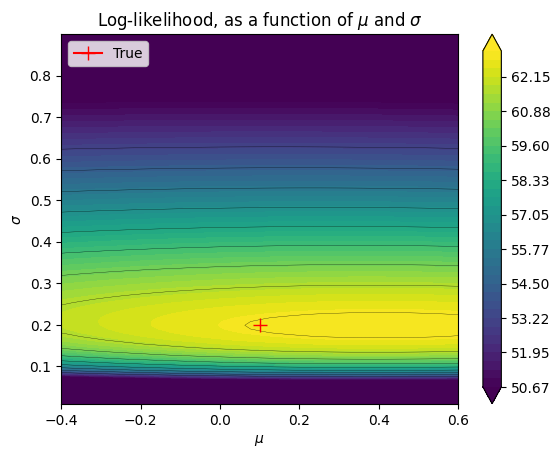

In [9]:
# Contour plot of the likelihood, as a function of alpha, beta
t = S.shape[0] - 1
spot = S[:, 0]

beta = 0.95
window = None

mus = torch.linspace(mu_true - 0.5, mu_true + 0.5, 100)
sigmas = torch.linspace(sigma_true - 0.19, sigma_true + 0.7, 100)
mus, sigmas = torch.meshgrid(mus, sigmas)
log_likelihood = torch.zeros(size=(100, 100))
for i in range(mus.shape[0]):
    for j in range(mus.shape[1]):
        model = Nig(mus[i, j], sigmas[i, j], xi_true, eta_true)
        log_likelihood[i, j] = model.forward(spot, t, delta_t=dt, beta=beta, window=window)

mean = torch.mean(log_likelihood).detach().item()
min = torch.min(log_likelihood).detach().item()
max = torch.max(log_likelihood).detach().item()
levels = np.linspace(mean - 2.0 , max, 40)

contour = plt.contourf(mus, sigmas, log_likelihood.detach(), levels=levels, cmap='viridis', extend='both')

levels = np.linspace(max - 10, max + 1, 10)
contour_line = plt.contour(mus, sigmas, log_likelihood.detach(), levels=levels, colors='black', linewidths=0.2)
plt.colorbar(contour)

marker_plot = plt.plot(mu_true.item(), sigma_true.item(), marker='+', color='red', markersize=10, label='True')
plt.legend(handles=marker_plot, loc='upper left')

plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')
plt.title(r'Log-likelihood, as a function of $\mu$ and $\sigma$')
plt.show()

-> Likelihood is very flat in the direction of alpha.  
It makes sense as alpha controles the heaviness of the tail, so we only have few observations useful to calibrate alpha.

In [10]:
# For each path, compute the MLE and estimate its mean and variance.
torch.manual_seed(42)
t = S.shape[0] - 1

beta = 0.95
window = None

n_paths = S.shape[1]
n_params = 4
stats = {
    "mle": torch.zeros(size=(n_paths, n_params)),
    "max_value": torch.zeros(size=(n_paths,)),
    "n_it": torch.zeros(size=(n_paths,)),
    "no_convergence": 0,
}

max_it = 10000
grad_norm_threshold = 1e-3
for i in range(n_paths):
    print(i)
    mu = Uniform(low=-0.5, high=0.5).sample()          # mu_true = 0.1
    sigma = Uniform(low=1e-4, high=1.0).sample()       # sigma_true = 0.2
    xi = Uniform(low=-5.0, high=5.0).sample()          # xi_true = -1.0
    eta = Uniform(low=1e-4, high=0.5).sample()         # eta_true = 0.01

    #print("Init: ", mu.item(), sigma.item(), xi.item(), eta.item())

    model = Nig(mu, sigma, xi, eta)
    #model.params["atanh_psi"] = torch.nn.Parameter(psi)
    #model.params["atanh_psi"].requires_grad = False
    #model.params["log_delta"].requires_grad = False
    #model.params["log_alpha"].requires_grad = False
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1, maximize=True)
    spot_prices = S[:, i]
    for j in range(max_it):
        optimizer.zero_grad()
        loss = model.forward(spot_prices, t=t, delta_t=dt, beta=beta, window=window)
        loss.backward()
        total_norm = torch.norm(torch.cat([p.grad.view(-1) for p in model.parameters() if p.grad is not None]))
        
        mu = model.params["mu"].detach()
        sigma = torch.exp(model.params["log_sigma"].detach())
        xi = model.params["xi"].detach()
        eta = torch.exp(model.params["log_neta"].detach())
        #print(f"Epoch {j}, Loss: {loss.item():.3f}, Grad Norm: {total_norm.item():.3f}, mu:{mu:.3f}, sigma: {sigma:.3f}, xi: {xi:.3f}, eta: {eta:.3f}")

        if total_norm < grad_norm_threshold:
            stats["n_it"][i] = j
            #print("Stopping: Gradient norm below threshold.")
            break
        if j == max_it - 1:
            stats["n_it"][i] = j
            stats["no_convergence"] += 1
            print("Maximum iteration reached.")
        optimizer.step()

    params = model.get_params()
    stats["mle"][i, 0] = params[0]
    stats["mle"][i, 1] = params[1]
    stats["mle"][i, 2] = params[2]
    stats["mle"][i, 3] = params[3]

    model = Nig(params[0], params[1], params[2], params[3])
    value = model.forward(spot_prices, t=t, delta_t=dt, beta=beta, window=window)
    stats["max_value"][i] = value

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [11]:
mean = torch.mean(stats["mle"], dim=0)
std = torch.std(stats["mle"], dim=0)
avg_it = torch.mean(stats["n_it"])
n_no_conv = stats["no_convergence"]

true_params = torch.tensor([mu_true.item(), sigma_true.item(), xi_true.item(), eta_true.item()])
avg_distance_to_argmax = torch.mean(torch.norm(stats["mle"] - true_params))

true_max_value = Nig(mu_true, sigma_true, xi_true, eta_true).forward(spot_prices, t=t, delta_t=dt, beta=beta, window=window).item()
avg_distance_to_max = torch.mean(torch.abs(stats["max_value"] - true_max_value)).item()

print(f"Average MLE: mu:{mean[0].item():.3f}, sigma:{mean[1].item():.3f}, xi:{mean[2].item():.3f}, eta:{mean[3].item():.3f}")
print(f"Std MLE: mu:{std[0].item():.3f}, sigma:{std[1].item():.3f}, xi:{std[2].item():.3f}, eta:{std[3].item():.3f}")
print(f"Average distance to true parameter: {avg_distance_to_argmax.item():.3f}")
print(f"Average relative error to the true maximum: {((true_max_value - avg_distance_to_max) / true_max_value):.3f}")
print(f"Average number of iteration to convergence {avg_it.item():.3f}")
print(f"Number of parameters where GD didn't converge: {n_no_conv} / {n_paths}")

Average MLE: mu:0.103, sigma:0.200, xi:-1.600, eta:0.010
Std MLE: mu:0.501, sigma:0.050, xi:9.825, eta:0.011
Average distance to true parameter: 311.522
Average relative error to the true maximum: 0.956
Average number of iteration to convergence 793.968
Number of parameters where GD didn't converge: 0 / 1000
